In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from scipy.special import expit

# ATE estimation
import statsmodels.api as sm
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from causalml.inference.meta import BaseSRegressor
from doubleml import DoubleMLData, DoubleMLPLR

# Custom modules
from feature_extraction.pretrained_models_xrv import load_torchxrayvision_model, extract_features_from_folder
from utils.project import set_root
from utils.io import save_results, load_results

In [ ]:
# Set working directory, dataset directory and directory for saving results
set_root()
dataset_dir = "data/pneumonia/all_unique"
results_dir = "results/comparison_learners/xray/label"

# Define the model name and path for saving results
model_name = "densenet121-res224-all"  # Pretrained model name
save_dir_rep = f"data/representations/pneumonia/{model_name}"

# Define file paths
features_path = os.path.join(save_dir_rep, "latent_features.npy")
labels_path = os.path.join(save_dir_rep, "labels.npy")

In [ ]:
# Feature extraction and saving (Only if the features and labels do not already exist)
if not os.path.exists(features_path) or not os.path.exists(labels_path):
    print(f"Extracting features using model '{model_name}'...")
    
    # Extract features and save them
    model = load_torchxrayvision_model(model_name)
    all_features, labels = extract_features_from_folder(
        dataset_dir,
        model,
        device='cpu',
        batch_size=32,
        save_path=save_dir_rep
    )
    
    print(f"Features extracted and saved to: {save_dir_rep}")
else:
    print(f"Features already exist in {save_dir_rep}. Skipping extraction.")

# Load extracted features
all_features = np.load(features_path)
labels = np.load(labels_path)

### Exploring the HCM Structure and its Effect on ATE estimation

Define confounder as the product of features from the pre-trained representation. This induces highly complicated confounding and hence complex nuisance functions, which are difficult to estimate for the ATE estimators. 

Given the structure of the simualted confounding, it is difficult to avoid the curse of dimensionality. Hence, as depicted below, under such confounding no estimator is able to obtain unbiased ATE estimates.

In [ ]:
# Define confounder as the product of features from the pre-trained representation (scale by max value to keep values in reasonable range) 
all_features_prod = np.log(np.prod(np.exp(all_features/np.max(all_features)), axis=1))

# Simulate treatment assignments
gamma_A = 0.1 # Effect of confounder on treatment assignment
pA = expit(all_features_prod * gamma_A)

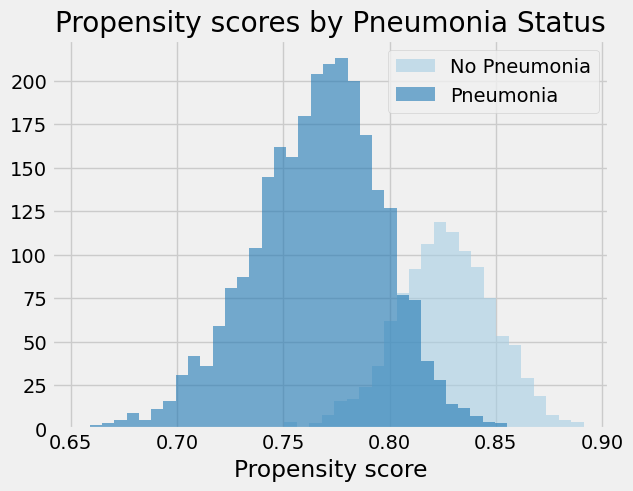

In [ ]:
# Depicting the distribution of the simulated propensity scores between pneumonia/non-pneumonia patients.
# Treatment assignment clearly depends on pneumonia status, hence inducing confounding.
group_no_pneu = [v for v, l in zip(pA, labels) if l == 0]
group_pneu = [v for v, l in zip(pA, labels) if l == 1]

# Plot histograms
plt.hist(group_no_pneu, bins='auto', alpha=0.6, label='No Pneumonia')
plt.hist(group_pneu, bins='auto', alpha=0.6, label='Pneumonia')

plt.title("Propensity scores by Pneumonia Status")
plt.xlabel("Propensity score")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# 1. Define simulation parameters
np.random.seed(42)  # For reproducibility
beta_true = 2.0     # True effect of A on Y
gammas_Y = 4   # Effect of confounder product on Y
gammas_A = 0.1 # Effect of confounder product on A

# Define confounder as the product of features from the pre-trained representation
all_features_prod = np.log(np.prod(np.exp(all_features/np.max(all_features)), axis=1))

# 2. Specify general parameters for simulation
n_samples, d_features = all_features.shape  # n samples, d=1024 features
n_runs = 5  # Number of simulation runs
ci_alpha_level = 0.05  # Alpha level for 1-alpha confidence intervals
z_score = norm.ppf(1 - ci_alpha_level / 2) # Z-score for 1-alpha confidence intervals

# 3. Initialize dictionaries to store estimates and confidence intervals
methods = ['Naive', 'S-Learner (NN)', 'S-Learner (RF)', 'DML (NN)', 'DML (RF)']
estimates_dict_complex = {method: [] for method in methods}
cis_dict_complex = {method: {'lower': [], 'upper': []} for method in methods}

# 4. Simulation Loop
for run in range(n_runs):
    print(f"\n--- Simulation Run {run + 1} ---")
    # Set a unique seed for each run for variability
    seed = 43 + run
    np.random.seed(seed)
    
    # a. Compute Treatment Assignment Probability
    pA = expit(all_features_prod * gammas_A) 

    # b. Sample Treatment Assignment
    #A = np.random.binomial(1, pA)
    A = (pA > 0.7).astype(int)

    # c. Generate Outcome Y
    noise = np.random.normal(loc=0, scale=1, size=n_samples)
    Y = beta_true * A + all_features_prod * gammas_Y + noise
    
    # d. Package into DataFrame
    df = pd.DataFrame({
        'Y': Y,
        'A': A
    })
    
    # 4.1. Naive OLS (Unadjusted) using statsmodels
    X_naive = sm.add_constant(df['A']) 
    model_naive = sm.OLS(df['Y'], X_naive).fit()
    beta_naive = model_naive.params['A']
    se_naive = model_naive.bse['A']
    ci_lower_naive = beta_naive - z_score * se_naive
    ci_upper_naive = beta_naive + z_score * se_naive
    estimates_dict_complex['Naive'].append(beta_naive)
    cis_dict_complex['Naive']['lower'].append(ci_lower_naive)
    cis_dict_complex['Naive']['upper'].append(ci_upper_naive)
    print(f"Naive OLS: β = {beta_naive:.3f}, SE = {se_naive:.3f}")
    
    ## Different Other ATE Estimators

    # 4.2.1. S-Learner (NN)
    outcome_model_nn = Pipeline([
        ('scaler', StandardScaler()),
        ('mlp', MLPRegressor(
            hidden_layer_sizes=(7, 5),
            activation='relu',
            solver='adam',
            max_iter=500,
            random_state=seed
        ))
    ])

    try:
        s_learner_nn = BaseSRegressor(outcome_model_nn) 
        s_ate_nn, s_ci_lower_nn, s_ci_upper_nn = s_learner_nn.estimate_ate(all_features, A, Y, return_ci=True)
        estimates_dict_complex['S-Learner (NN)'].append(s_ate_nn[0])
        cis_dict_complex['S-Learner (NN)']['lower'].append(s_ci_lower_nn[0])
        cis_dict_complex['S-Learner (NN)']['upper'].append(s_ci_upper_nn[0])
        print(f"S-Learner (NN): β = {s_ate_nn[0]:.3f}")
    except Exception as e:
        print(f"Run {run+1}: S-Learner (NN) failed with error: {e}")
        estimates_dict_complex['S-Learner (NN)'].append(np.nan)
        cis_dict_complex['S-Learner (NN)']['lower'].append(np.nan)
        cis_dict_complex['S-Learner (NN)']['upper'].append(np.nan)
    
    #  4.2.2. S-Learner (RF) 
    outcome_model_rf = RandomForestRegressor(n_estimators=10, max_depth=2, random_state=42)
    try:
        s_learner_rf = BaseSRegressor(outcome_model_rf) 
        s_ate_rf, s_ci_lower_rf, s_ci_upper_rf = s_learner_rf.estimate_ate(all_features, A, Y, return_ci=True)
        estimates_dict_complex['S-Learner (RF)'].append(s_ate_rf[0])
        cis_dict_complex['S-Learner (RF)']['lower'].append(s_ci_lower_rf[0])
        cis_dict_complex['S-Learner (RF)']['upper'].append(s_ci_upper_rf[0])
        print(f"S-Learner (RF): β = {s_ate_rf[0]:.3f}")
    except Exception as e:
        print(f"Run {run+1}: S-Learner (RF) failed with error: {e}")
        estimates_dict_complex['S-Learner (RF)'].append(np.nan)
        cis_dict_complex['S-Learner (RF)']['lower'].append(np.nan)
        cis_dict_complex['S-Learner (RF)']['upper'].append(np.nan)

    # 4.3. DoubleML with Neural Network Nuisance and Random Forest Estimators
    # Convert all_features to DataFrame
    X_dml_df = pd.DataFrame(
        all_features,  # Use scaled features
        columns=[f"feat_{i}" for i in range(d_features)]
    )
    
    # Add outcome and treatment to DoubleMLData via column names
    X_dml_df['Y'] = df['Y']
    X_dml_df['A'] = df['A']

    # Create DoubleMLData
    data_dml = DoubleMLData(X_dml_df, "Y", "A")

    # 4.3.1. DoubleML with Neural Network Nuisance Estimators
    try:
        # Define nuisance models with neural networks
        ml_g_nn = Pipeline([
            ('scaler', StandardScaler()),
            ('mlp', MLPRegressor(
                hidden_layer_sizes=(7, 5),
                activation='relu',
                solver='adam',
                max_iter=500,
                random_state=seed
            ))
        ])

        # Define nuisance models with neural networks
        ml_m_nn = Pipeline([
            ('scaler', StandardScaler()),
            ('mlp', MLPClassifier(
                hidden_layer_sizes=(7, 5),
                activation='relu',
                solver='adam',
                max_iter=500,
                random_state=seed
            ))
        ])
    
        # Instantiate and fit DoubleMLPLR
        dml_plr_nn = DoubleMLPLR(data_dml, ml_g_nn, ml_m_nn, n_folds=2)
        dml_plr_nn.fit()
        beta_dml_nn = dml_plr_nn.coef[0]
        se_dml_nn = dml_plr_nn.se[0]
        estimates_dict_complex['DML (NN)'].append(beta_dml_nn)
        # 95% Confidence Interval
        ci_lower_dml_nn = beta_dml_nn - z_score * se_dml_nn
        ci_upper_dml_nn = beta_dml_nn + z_score * se_dml_nn
        cis_dict_complex['DML (NN)']['lower'].append(ci_lower_dml_nn)
        cis_dict_complex['DML (NN)']['upper'].append(ci_upper_dml_nn)
        print(f"DML (NN): β = {beta_dml_nn:.3f}, SE = {se_dml_nn:.3f}")
    except Exception as e:
        print(f"Run {run+1}: DML (NN) failed with error: {e}")
        estimates_dict_complex['DML (NN)'].append(np.nan)
        cis_dict_complex['DML (NN)']['lower'].append(np.nan)
        cis_dict_complex['DML (NN)']['upper'].append(np.nan)
    
    # 4.3.2. DoubleML with Random Forest Nuisance Estimators

    try:
        # Define nuisance models with neural networks
        ml_g_rf = RandomForestRegressor(n_estimators=10, max_depth=2, random_state=42)
        ml_m_rf = RandomForestClassifier(n_estimators=10, max_depth=2, random_state=42)
    
        # Instantiate and fit DoubleMLPLR
        dml_plr_rf = DoubleMLPLR(data_dml, ml_g_rf, ml_m_rf, n_folds=2) 
        dml_plr_rf.fit()
        beta_dml_rf = dml_plr_rf.coef[0]
        se_dml_rf = dml_plr_rf.se[0]
        estimates_dict_complex['DML (RF)'].append(beta_dml_rf)
        # 95% Confidence Interval
        ci_lower_dml_rf = beta_dml_rf - z_score * se_dml_rf
        ci_upper_dml_rf = beta_dml_rf + z_score * se_dml_rf
        cis_dict_complex['DML (RF)']['lower'].append(ci_lower_dml_rf)
        cis_dict_complex['DML (RF)']['upper'].append(ci_upper_dml_rf)
        print(f"DML (RF): β = {beta_dml_rf:.3f}, SE = {se_dml_rf:.3f}")
    except Exception as e:
        print(f"Run {run+1}: DML failed with error: {e}")
        estimates_dict_complex['DML (RF)'].append(np.nan)
        cis_dict_complex['DML (RF)']['lower'].append(np.nan)
        cis_dict_complex['DML (RF)']['upper'].append(np.nan)

In [43]:
# 5. Create a directory for the run and save the results
experiment_name = "exploring_hcm"
experiment_dir = os.path.join('results/hcm', experiment_name)
save_results(experiment_dir, estimates_dict_complex, cis_dict_complex)

### Plotting Results

In [44]:
# Load the results from the previous experiment
estimates_dict_complex, cis_dict_complex = load_results(experiment_dir)

<Figure size 800x400 with 0 Axes>

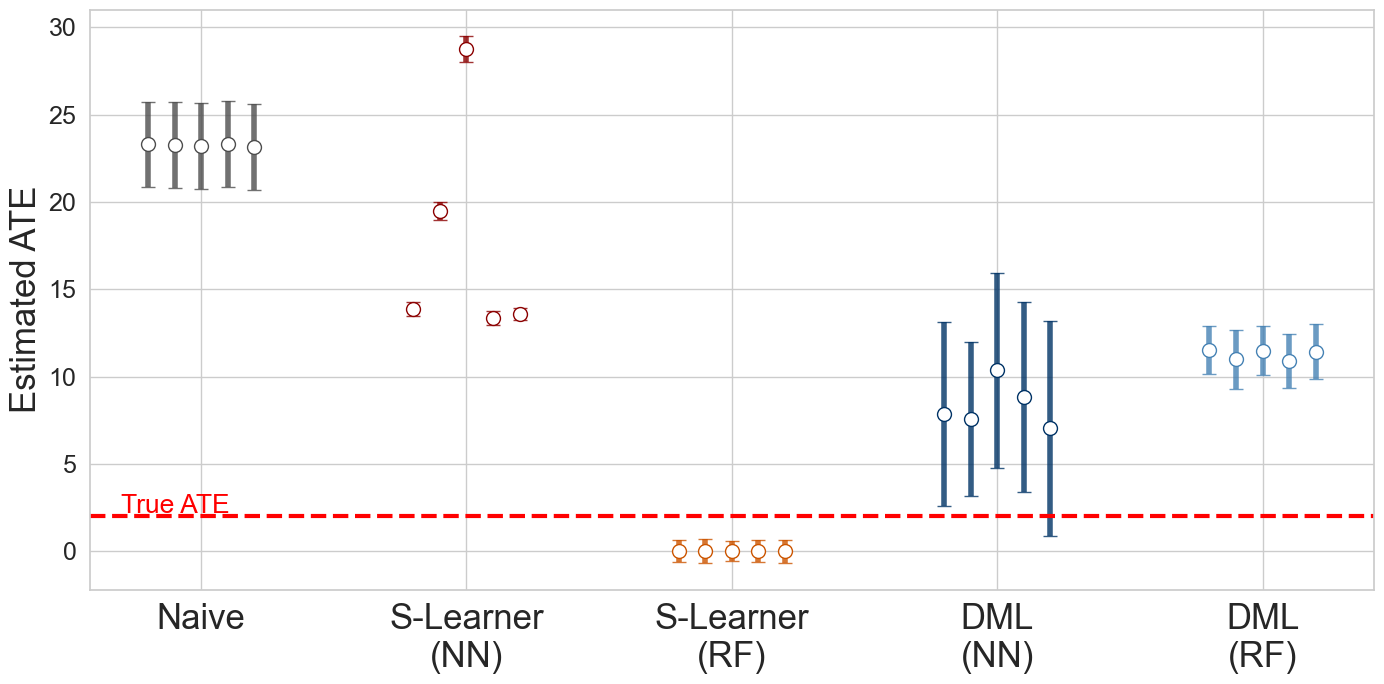

In [ ]:
# 6. Aggregate Results
# Convert estimates_dict to DataFrame for easier manipulation
methods_complex = ['Naive', 'S-Learner (NN)', 'S-Learner (RF)', 'DML (NN)', 'DML (RF)']
estimates_df = pd.DataFrame(estimates_dict_complex)
cis_lower_df = pd.DataFrame({method: cis_dict_complex[method]['lower'] for method in methods_complex})
cis_upper_df = pd.DataFrame({method: cis_dict_complex[method]['upper'] for method in methods_complex})

# Prepare data for plotting
plot_data = []
for method in methods_complex:
    for run in range(n_runs):
        if not np.isnan(estimates_df.loc[run, method]):
            plot_data.append({
                'Method': method,
                'Run': run + 1,
                'Estimate': estimates_df.loc[run, method],
                'CI Lower': cis_lower_df.loc[run, method],
                'CI Upper': cis_upper_df.loc[run, method]
            })

plot_df = pd.DataFrame(plot_data)

# 7. Plotting parameters
# Assign numerical positions to methods
method_positions = {method: idx for idx, method in enumerate(methods_complex)}

# Define a consistent color palette
estimator_colors = {
    "Naive": "#4D4D4D", 
    "S-Learner (NN)": "#8B0000", 
    "S-Learner (RF)": "#CC5500",  
    "DML (NN)": "#003366",  
    "DML (RF)": "#4682B4",  
}

# 8. Plotting
sns.set(style="whitegrid")
plt.figure(figsize=(14, 7), facecolor='white')
ax = plt.gca()

fontsize_plot = 25

# Define offsets for each run to spread the dots
offset_range = 0.2  # Total range for offsets
offsets = np.linspace(-offset_range, offset_range, n_runs)

# Plot each estimate with its confidence interval
for idx, row in plot_df.iterrows():
    method = row['Method']
    run = row['Run']
    x = method_positions[method] + offsets[run - 1]
    estimate = row['Estimate']
    ci_lower = row['CI Lower']
    ci_upper = row['CI Upper']
    color = estimator_colors.get(method, "black") 

    # Plot the confidence interval as a thicker error bar
    ax.errorbar(x, estimate, yerr=[[estimate - ci_lower], [ci_upper - estimate]],fmt='none', ecolor=color, elinewidth=4, capsize=5, alpha=0.8)

    # Plot the estimate as a hollow circle
    ax.plot(x, estimate, marker='o', markerfacecolor='white', markeredgecolor=color, markersize=10, linestyle='')

# 6. Add true ATE line
plt.axhline(y=beta_true, color='red', linestyle='--', linewidth=3, label='True ATE')
plt.text(x=-0.3, y=beta_true + 0.2, s="True ATE", fontsize=19, color='red')

methods_labels = ["Naive", "S-Learner\n(NN)", "S-Learner\n(RF)", "DML\n(NN)", "DML\n(RF)"]
plt.xticks(ticks=list(method_positions.values()), labels=methods_labels, fontsize=fontsize_plot)

plt.yticks(fontsize=18)
plt.ylabel("Estimated ATE", fontsize=fontsize_plot)

# 8. Create a custom legend for the estimators
handles = [plt.Line2D([0], [0], marker='o', color='w', label=method,markerfacecolor='white', markeredgecolor=color, 
                      markersize=8) 
    for method, color in estimator_colors.items()
]

plt.tight_layout()
plot_path = os.path.join(experiment_dir, 'ate_hcm.pdf')
plt.savefig(plot_path, dpi=300, bbox_inches='tight', facecolor='white')
plt.show()